# To reproduce Extended Data Fig 

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random 
import scipy
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from torch.utils.data import DataLoader, TensorDataset,ConcatDataset
from scipy.stats import zscore

from sklearn.neighbors import KDTree
from scipy.spatial import cKDTree

import scanpy as sc
import anndata
import torch

/home/users/siyuhe/.local/lib/python3.12/site-packages/leidenalg/VertexPartition.py:413: SyntaxWarning: invalid escape sequence '\m'
  .. math:: Q = \\frac{1}{m} \\sum_{ij} \\left(A_{ij} - \\frac{k_i^\mathrm{out} k_j^\mathrm{in}}{m} \\right)\\delta(\\sigma_i, \\sigma_j),
/home/users/siyuhe/.local/lib/python3.12/site-packages/leidenalg/VertexPartition.py:788: SyntaxWarning: invalid escape sequence '\m'
  .. math:: Q = \\sum_{ij} \\left(A_{ij} - \\gamma \\frac{k_i^\mathrm{out} k_j^\mathrm{in}}{m} \\right)\\delta(\\sigma_i, \\sigma_j),
/home/users/siyuhe/.local/lib/python3.12/site-packages/leidenalg/Optimiser.py:27: SyntaxWarning: invalid escape sequence '\g'
  implementation therefore does not guarantee subpartition :math:`\gamma`-density.
/home/users/siyuhe/.local/lib/python3.12/site-packages/leidenalg/Optimiser.py:346: SyntaxWarning: invalid escape sequence '\s'
  .. math:: Q = \sum_k \\lambda_k Q_k.


In [3]:
import sys
sys.path.append('../../')
import coral

In [4]:
adata_rna = sc.read_h5ad('../../coral_storage/Data_SpatialGlue/Dataset13_Simulation1/adata_RNA.h5ad')
adata_adt = sc.read_h5ad('../../coral_storage/Data_SpatialGlue/Dataset13_Simulation1/adata_ADT.h5ad')

In [5]:
adata_rna

AnnData object with n_obs × n_vars = 1296 × 1000
    uns: 'log1p'
    obsm: 'nsfac', 'spatial', 'spfac'
    varm: 'nsload', 'spload'
    layers: 'counts'

In [6]:
adata_adt

AnnData object with n_obs × n_vars = 1296 × 100
    uns: 'log1p'
    obsm: 'nsfac', 'spatial', 'spfac'
    varm: 'nsload', 'spload'
    layers: 'counts'

In [9]:
adata_rna.obs['Annotation']= 1*np.array(adata_rna.obsm['spfac'][:,0] + 2*adata_rna.obsm['spfac'][:,1] + 3*adata_rna.obsm['spfac'][:,2] + 4*adata_rna.obsm['spfac'][:,3])
annotation_mapping = {
    1.0: 'factor1',
    2.0: 'factor2',
    3.0: 'factor3',
    4.0: 'factor4',
    0.0: 'backgr'  
}
adata_rna.obs['Annotation'] = adata_rna.obs['Annotation'].map(annotation_mapping)


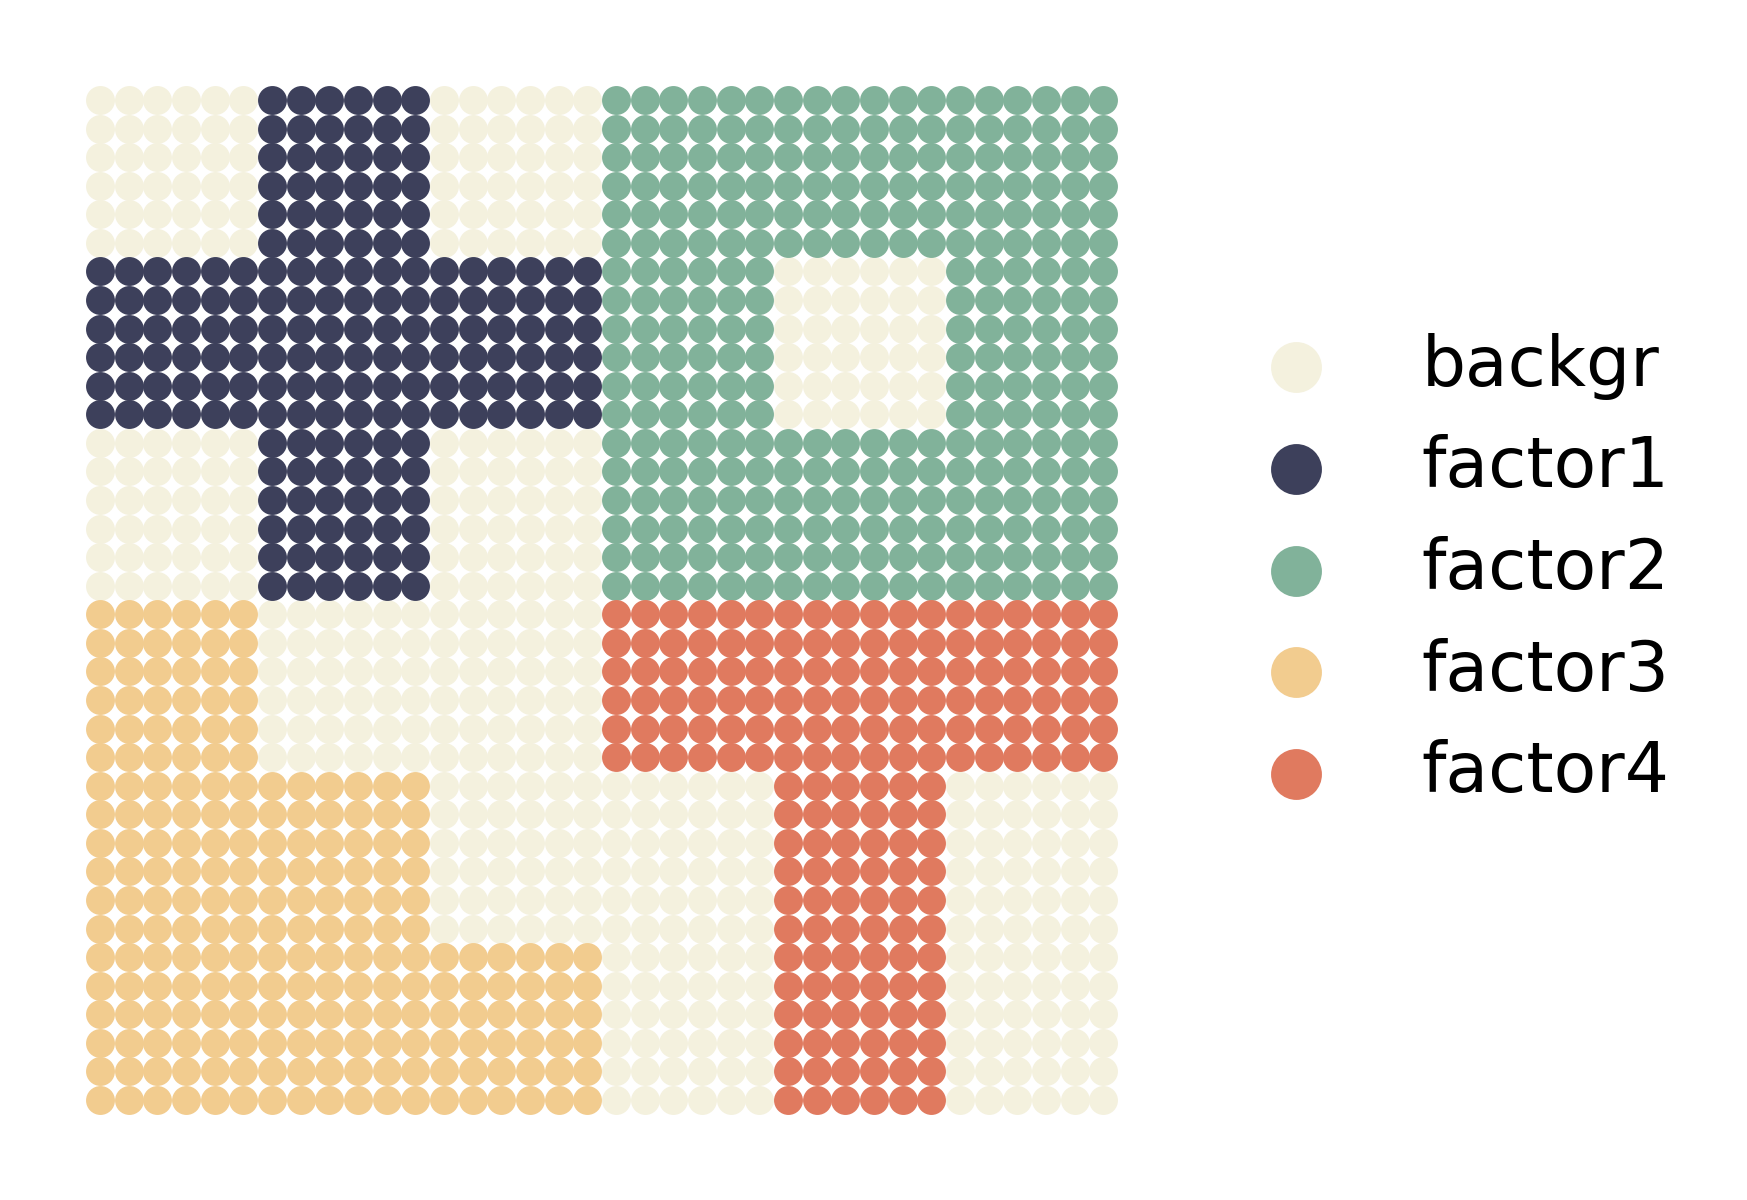

In [18]:
coral.utils.plot_spatial(
                        adata_rna,
                        res = 0.7, # adjust for resolution of cluster 
                        use_rep_for_cluster = None,  # adjust for the variable to be clustered
                        to_plot_var = 'Annotation',
                        need_lognormed = False, # if the data is not lognormed, select True
                        size =10,
                        figsize=(3.6,2.5),
                        legd = True,
                        invert_yaxis=False,                   
                        axis_=False,
                        legend_fontsize = 10,
                        legend_markerscale = 2,
                        color_list = [ '#f4f1de','#3d405b', '#81b29a', '#f2cc8f', '#e07a5f']
                        )

In [24]:
adata_downsampled = coral.utils.downsample_spatial_data(adata_rna)

In [40]:
sc.read_h5ad('../../coral_storage/coral_results/simulation/downsized_m1.h5ad').X.max()



np.float32(4.535983)

In [39]:
adata_downsampled.X.max()

np.float32(192.0)

In [61]:
coral.utils.plot_spatial(
                        adata_downsampled,
                        res = 1.2, # adjust for resolution of cluster 
                        use_rep_for_cluster = 'X_pca',  # adjust for the variable to be clustered
                        to_plot_var = 'cluster',
                        need_lognormed = True, # if the data is not lognormed, select True
                        size =140,
                        n_neighbors=15,
                        figsize=(3.5,2.7),
                        legd = True,
                        invert_yaxis=False,                   
                        axis_=False,
                        legend_fontsize=10,
                        legend_markerscale=1,
                        color_list = ['#e07a5f','#f4f1de', '#f2cc8f', '#81b29a', '#3d405b', ]
                        )

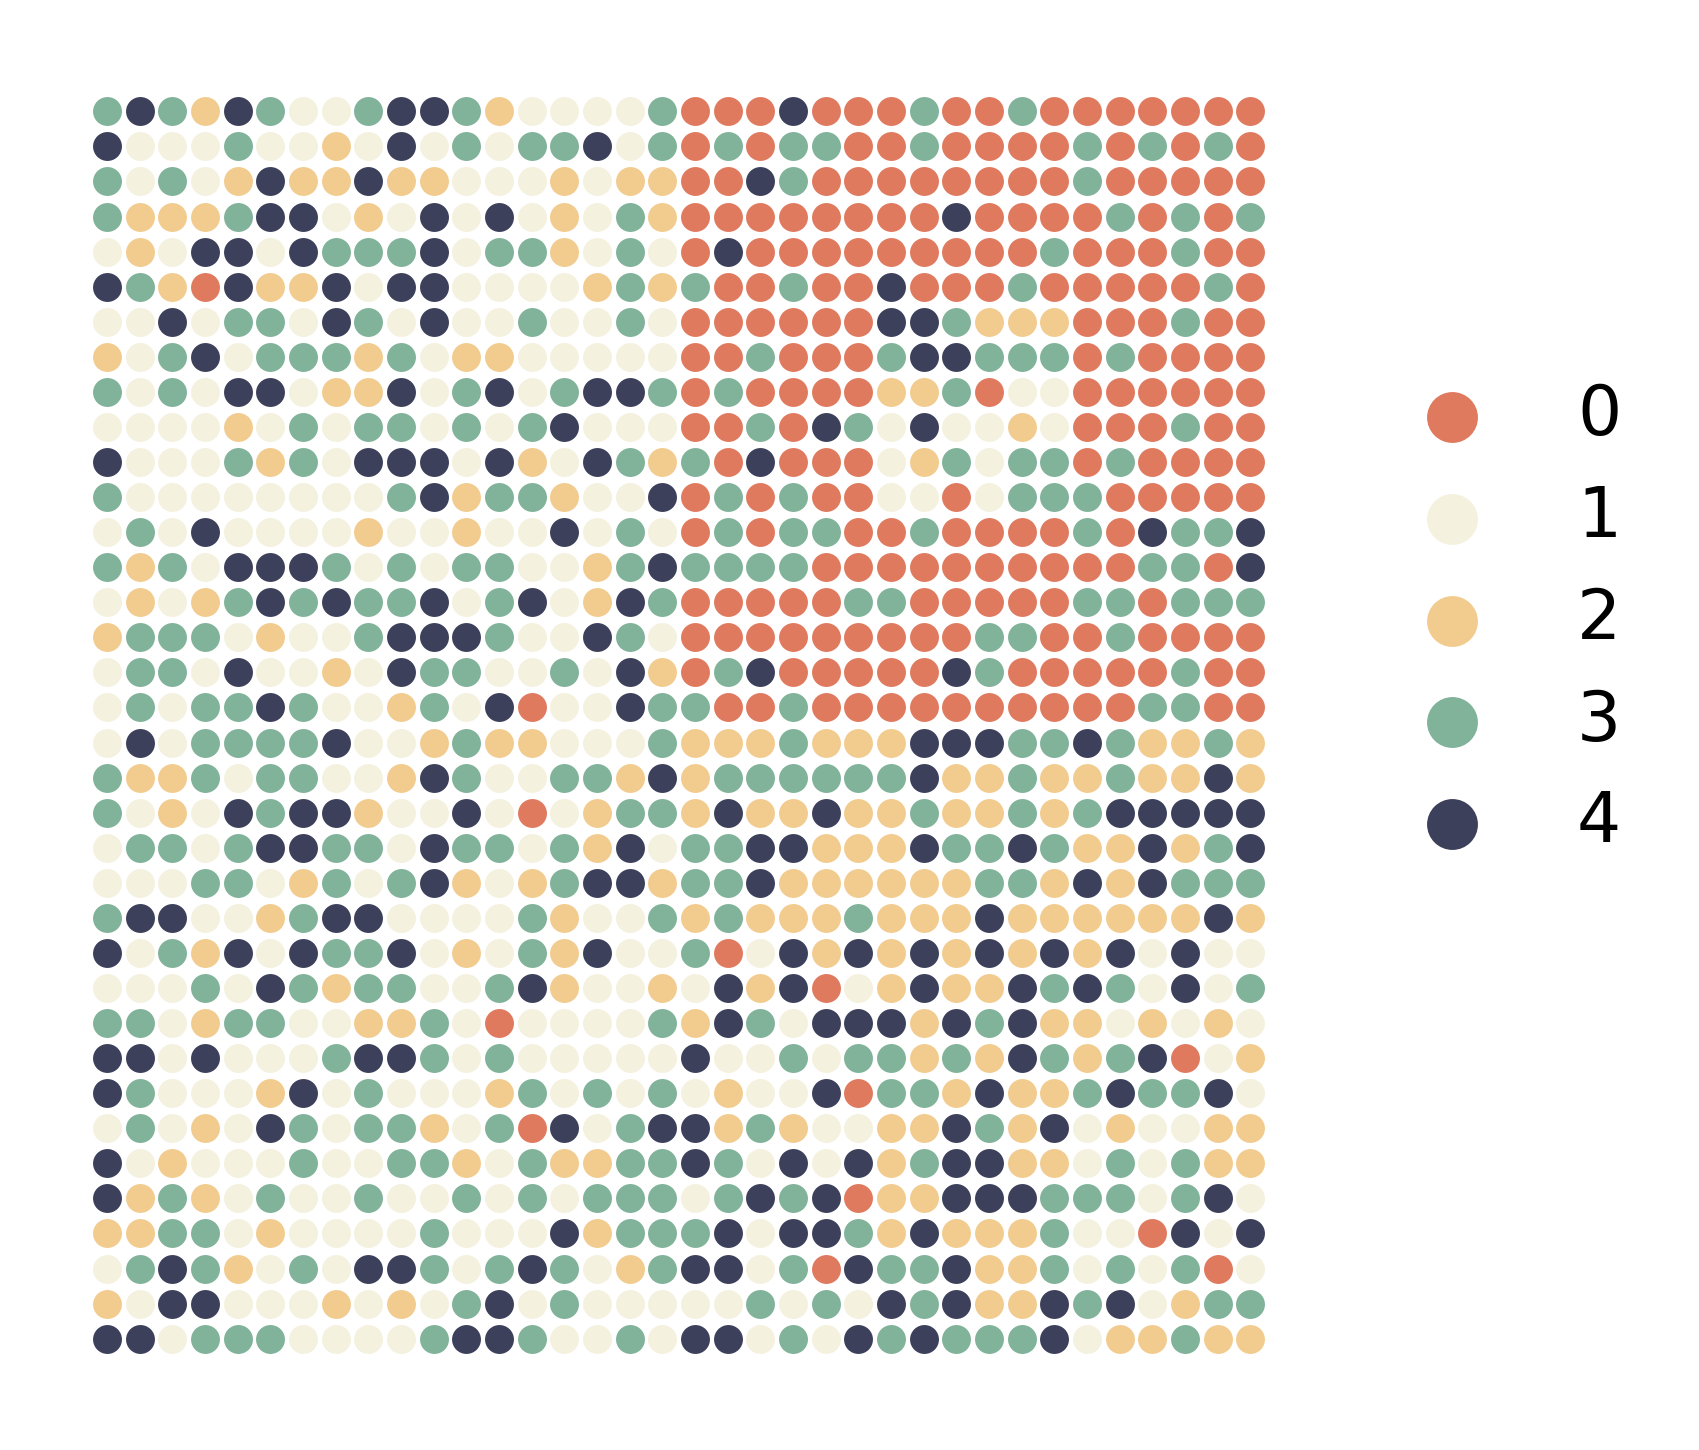

In [75]:
coral.utils.plot_spatial(
                        adata_adt,
                        res = 0.7, # adjust for resolution of cluster 
                        use_rep_for_cluster = 'X_pca',  # adjust for the variable to be clustered
                        to_plot_var = 'cluster',
                        need_lognormed = True, # if the data is not lognormed, select True
                        size =10,
                        figsize=(3.5,3),
                        legd = True,
                        invert_yaxis=False,                   
                        axis_=False,
                        legend_markerscale = 2,
                        color_list = ['#e07a5f','#f4f1de', '#f2cc8f', '#81b29a', '#3d405b', ]
                        )

In [6]:
#adata_downsampled.write('/hpc/mydata/siyu.he/coral_storage/coral_results/simulation/downsized_m1.h5ad')


In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print("GPU is available.")
    gpu_count = torch.cuda.device_count()
    print(f"Number of GPUs available: {gpu_count}")
    for i in range(gpu_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("GPU is not available.")
    

GPU is available.
Number of GPUs available: 1
GPU 0: NVIDIA H200


In [77]:
# add cluster to hires_adata
adata_adt = coral.utils.add_cluster(adata_adt,
                                  res = 0.7, # adjust for resolution of cluster 
                                  use_rep_for_cluster = 'X_pca',  # adjust for the variable to be clustered
                                  need_lognormed = True
                                 )
# here we just set the cluster of high-res data as the cell type, if an annotation exists such as mannual label, should work too

adata_adt.obs['cell_type'] = adata_adt.obs['cluster']

In [80]:
adata_downsampled

AnnData object with n_obs × n_vars = 144 × 1000
    obsm: 'spatial'

In [82]:
combined_expr, hires_coords, one_hot_cell_types, spot_indices, lowres_expr = coral.utils.preprocess_data(adata_downsampled, adata_adt)
    
dataloader = coral.utils.prepare_local_subgraphs(combined_expr, hires_coords, one_hot_cell_types, 
                                           spot_indices, lowres_expr,n_neighbors=40)    


/oak/stanford/groups/quake/siyu/Coral_project/notebooks/0.ExtendedDataFig1/../../coral/utils/preprocessing.py:130: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  return dataloader


In [83]:
model, optimizer = coral.model.create_model(lowres_dim = adata_downsampled.shape[1],
                                            hires_dim = adata_adt.shape[1],
                                            lowres_size = adata_downsampled.shape[0],
                                            hires_size = adata_adt.shape[0],
                                            cell_type_dim=one_hot_cell_types.shape[1],                                          
                                            latent_dim=64, 
                                            hidden_channels=128, 
                                            v_dim = 1
                                          )
model.to(device)

CORAL_model(
  (encoder_visium): Sequential(
    (0): Linear(in_features=1005, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (encoder_codex): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (encoder): Sequential(
    (0): Linear(in_features=1105, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (zi_prior): Sequential(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (cross_attention): CrossAttentionLayer(
    (query_proj): Linear(in_features=64, out_features=64, bias=True)
    (key_proj): Linear(in_features=64, out_features=64, bias=True)
    (value_proj): Linear(in_features=64, out_features=64, bias=True)
    (softmax): Softmax(dim=-1)
  )
  (deconv): Dec

In [84]:
coral.trainer.train_model(model, optimizer, dataloader, epochs = 100 ,device = device)


Epoch 0, Loss: 4501212.912037037
Epoch 1, Loss: 4325770.444444444
Epoch 2, Loss: 4177122.524691358
Epoch 3, Loss: 4073648.825617284
Epoch 4, Loss: 4033792.7052469137
Epoch 5, Loss: 4020716.7299382715
Epoch 6, Loss: 4014095.12808642
Epoch 7, Loss: 4010425.327160494
Epoch 8, Loss: 4004081.3209876544
Epoch 9, Loss: 4001909.936728395
Epoch 10, Loss: 3998010.214506173
Epoch 11, Loss: 3994338.2546296297
Epoch 12, Loss: 3994161.2438271604
Epoch 13, Loss: 3989329.5694444445
Epoch 14, Loss: 3985620.936728395
Epoch 15, Loss: 3987887.2700617285
Epoch 16, Loss: 3985338.7191358022
Epoch 17, Loss: 3981785.233024691
Epoch 18, Loss: 3980227.3703703703
Epoch 19, Loss: 3980408.549382716
Epoch 20, Loss: 3975407.435185185
Epoch 21, Loss: 3977416.1836419753
Epoch 22, Loss: 3972582.8703703703
Epoch 23, Loss: 3972916.3518518517
Epoch 24, Loss: 3972598.8317901236
Epoch 25, Loss: 3967746.87191358
Epoch 26, Loss: 3965516.300925926
Epoch 27, Loss: 3965111.3703703703
Epoch 28, Loss: 3963034.560185185
Epoch 29, Lo

In [85]:
# Define the path where you want to save the model
model_save_path = "model.pth"
optimizer_save_path = "optimizer.pth"
# Save the model's state_dict
torch.save(model.state_dict(), model_save_path)
# Save the optimizer's state_dict
torch.save(optimizer.state_dict(), optimizer_save_path)

In [177]:
adata_model_gener, edges_all, attn_weights_all = coral.inference.generate_and_validate(model, dataloader,device, adata_adt)

adata_model_gener

AnnData object with n_obs × n_vars = 1296 × 100
    obsm: 'generated_expr', 'coral', 'spatial', 'v_values', 'cell_types'

In [124]:
coral.utils.plot_spatial(
                        adata_model_gener,
                        res = 0.05, # adjust for resolution of cluster 
                        use_rep_for_cluster = 'coral',  # adjust for the variable to be clustered
                        to_plot_var = 'cluster',
                        need_lognormed = True, # if the data is not lognormed, select True
                        size =30,
                        figsize=(4.5,4.2),
                        legd = True,
                        invert_yaxis=False,                   
                        axis_=False,
                        legend_markerscale = 2,
                        color_list = ['#e07a5f','#f4f1de', '#f2cc8f', '#81b29a', '#3d405b', ]
                        )

In [100]:
dataloader = coral.utils.prepare_local_subgraphs(combined_expr, hires_coords, one_hot_cell_types, 
                                           spot_indices, lowres_expr,n_neighbors=10) 

/oak/stanford/groups/quake/siyu/Coral_project/notebooks/0.ExtendedDataFig1/../../coral/utils/preprocessing.py:130: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  return dataloader


In [107]:
for batch in dataloader:
    coral.utils.visualize_subgraph(batch[0])
    break  # Visualize only the first batch

In [125]:
adata_model_gener.obs['Annotation'] = adata_rna.obs['Annotation']

In [137]:
coral.utils.plot_latent_umap(adata_model_gener,rep='coral',to_plot_var='Annotation')

/home/users/siyuhe/.local/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Figure size 1700x1500 with 0 Axes>

In [153]:
np.array(adata_model_gener.obsm['generated_expr']).min()

np.float32(0.8904612)

In [146]:
np.array(adata_model_gener.X).min()

np.float32(0.0)

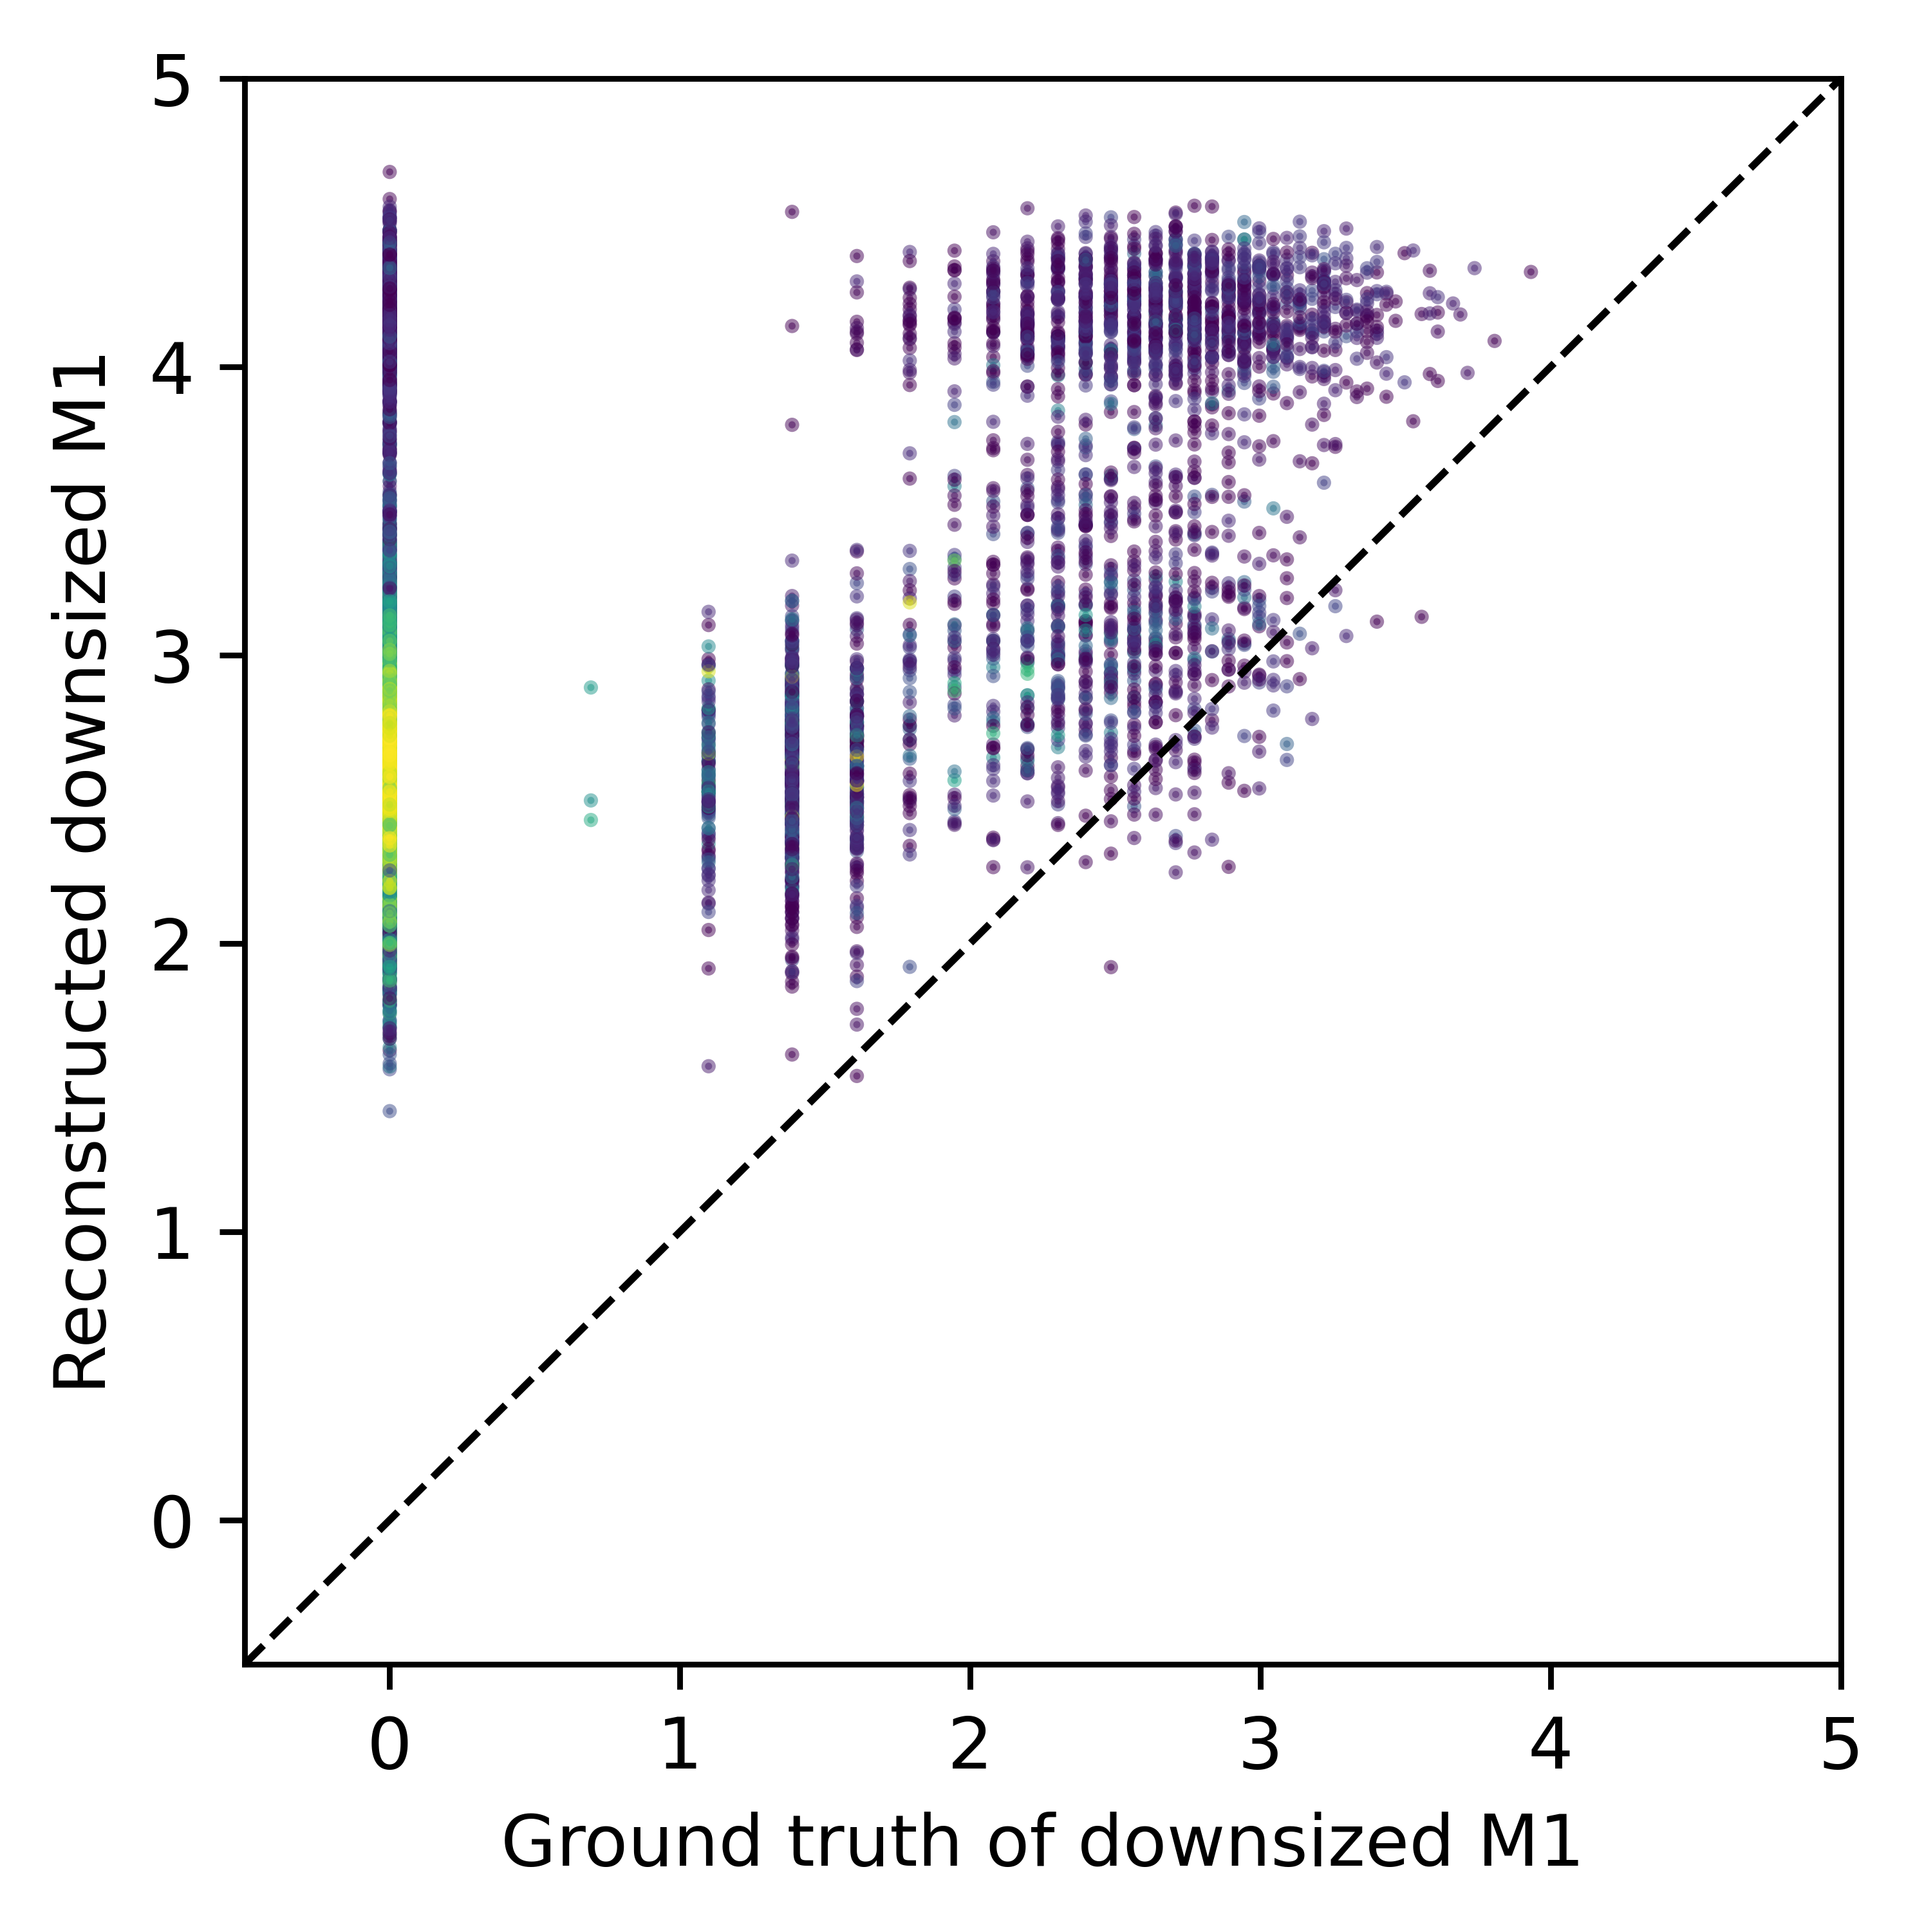

In [156]:
coral.utils.display_reconst(
                pd.DataFrame(np.log(np.array(adata_rna.X)+1)),
                pd.DataFrame(np.log(np.array(adata_model_gener.obsm['generated_expr'])+1)),
                density=True,
                x_label='Ground truth of downsized M1',
                y_label='Reconstructed downsized M1',
                size=(4,4),
                min_val=-0.5,
                max_val=5,
               )

In [158]:
coral.utils.display_reconst(
                pd.DataFrame((np.array(adata_adt.X))),
                pd.DataFrame((np.array(adata_model_gener.X))),
                density=True,
                x_label='Ground truth of Modality 2',
                y_label='Reconstructed Modality 2',
                size=(4,4),
                min_val=-10,
                max_val=650,
               )

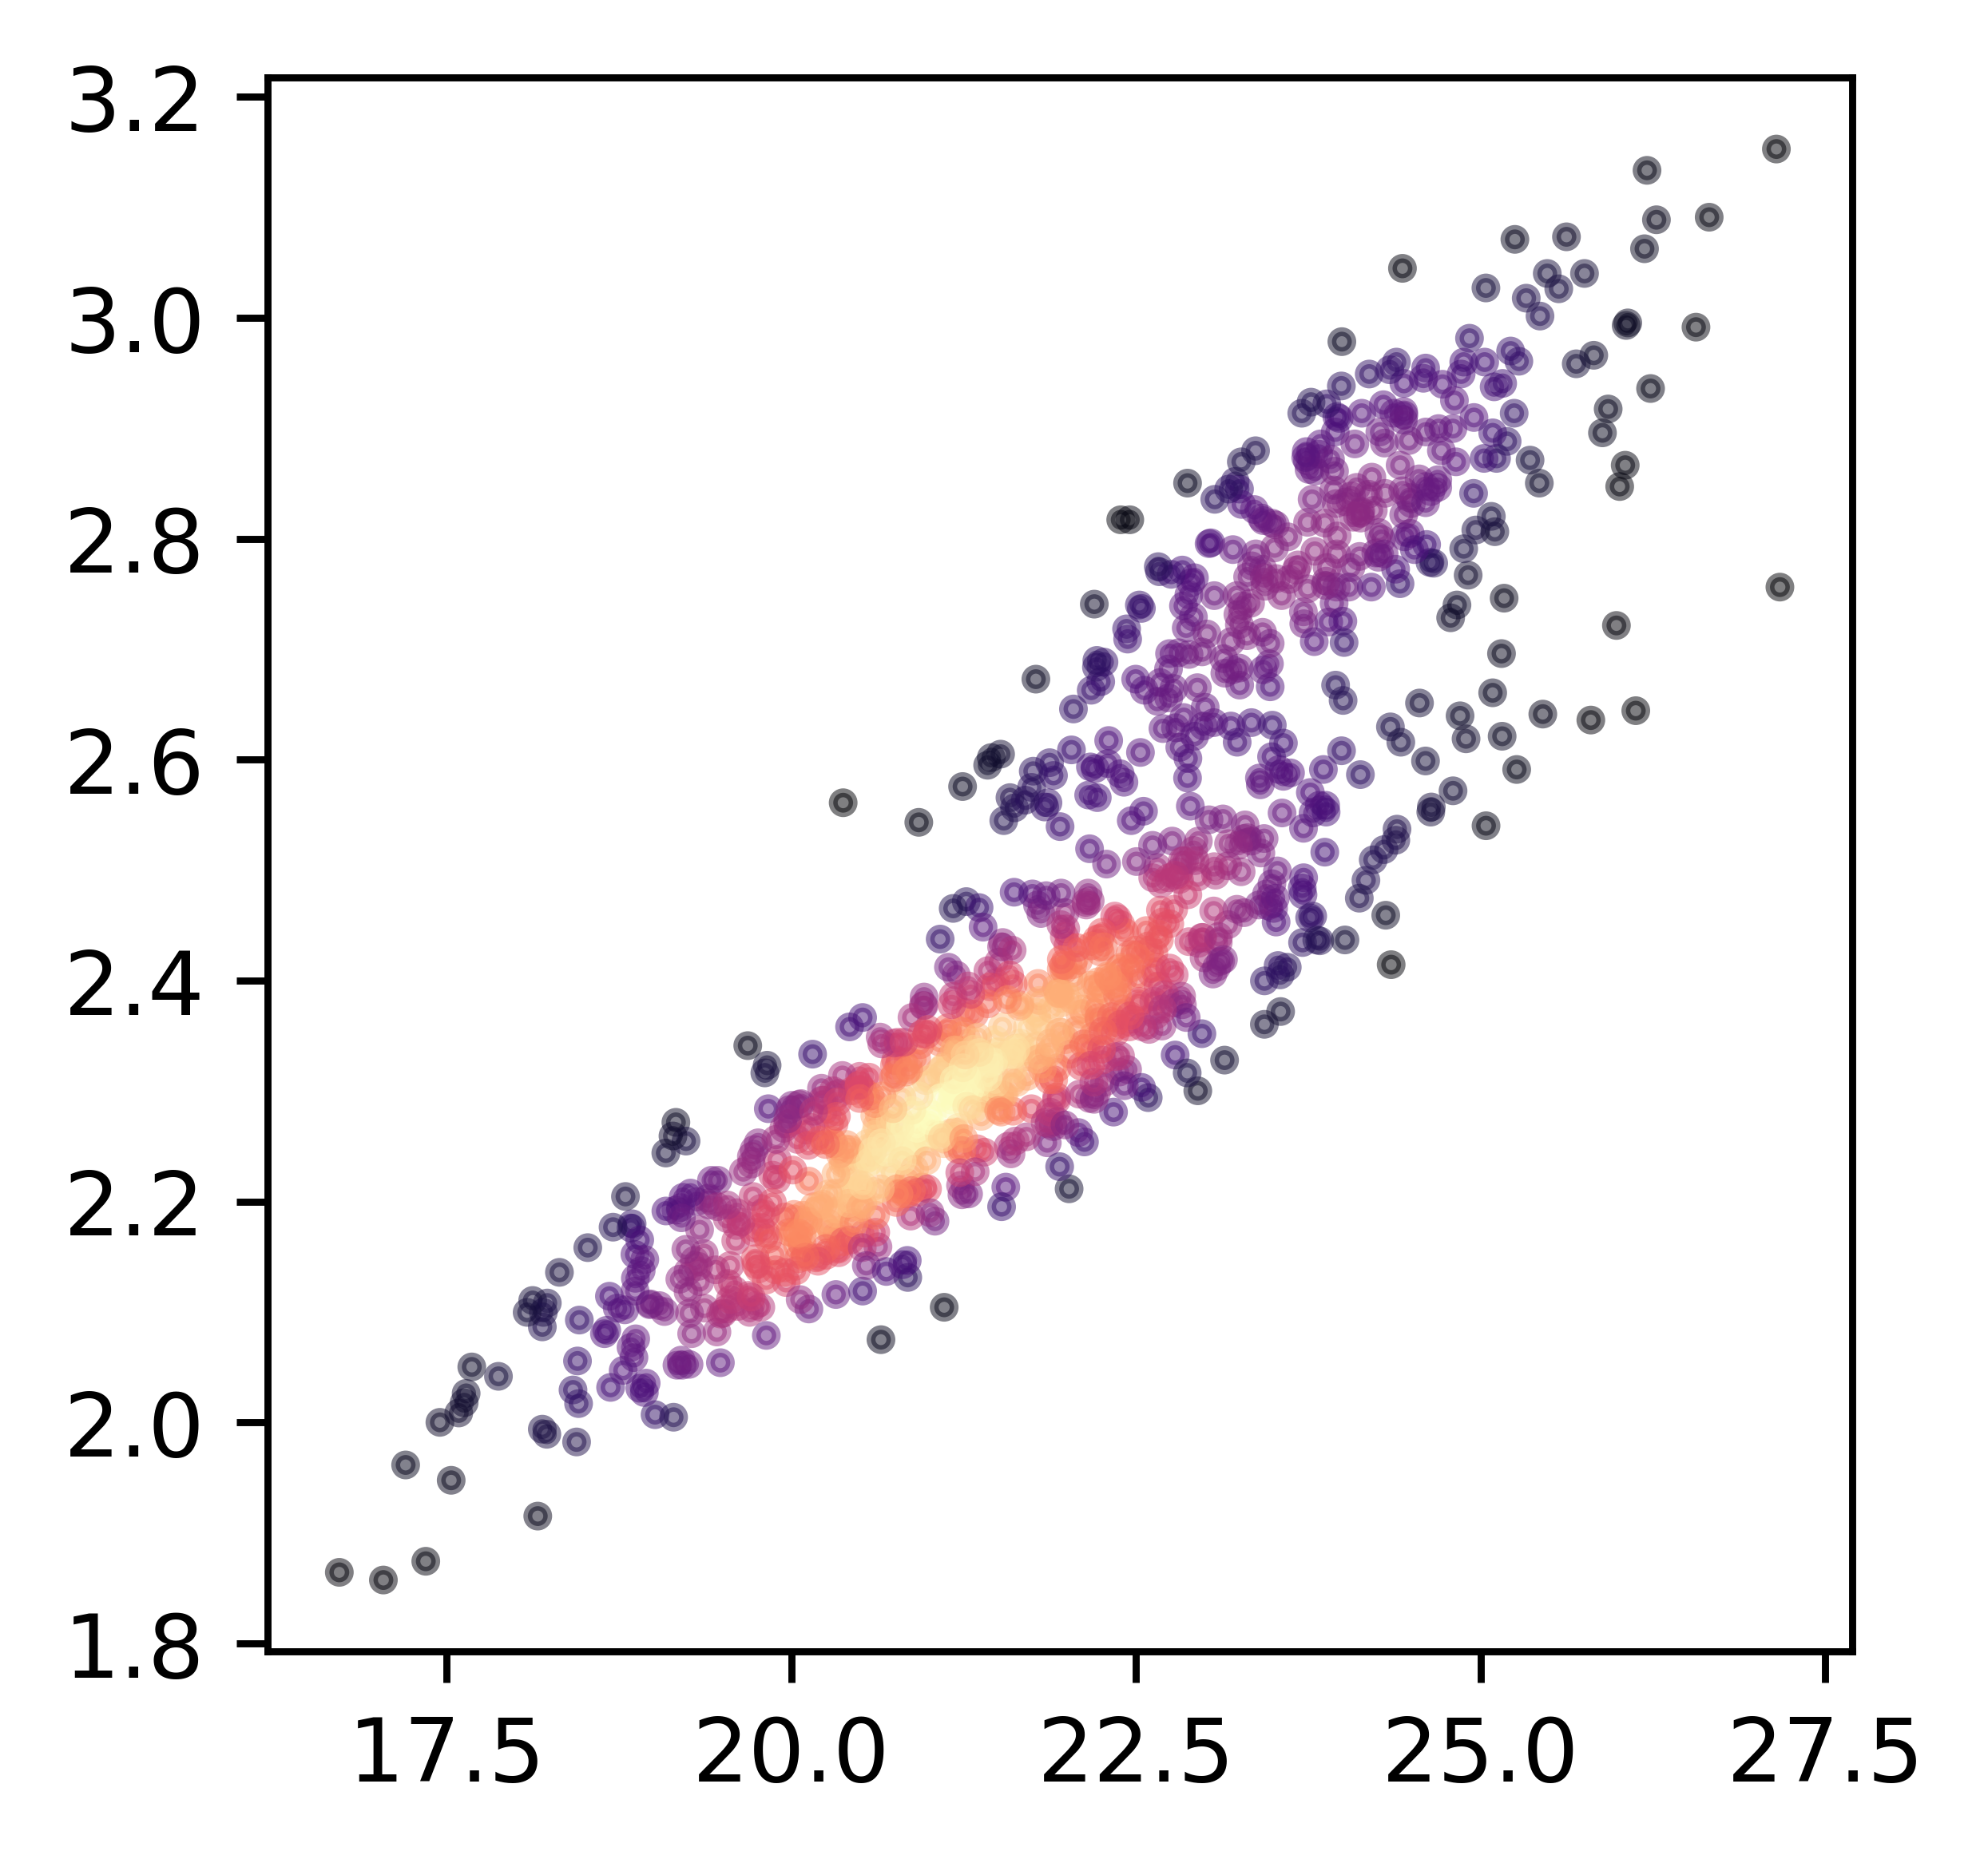

In [160]:
from scipy.stats import gaussian_kde
df_true_sample = pd.DataFrame(adata_model_gener.obsm['generated_expr'].mean(axis=0))
df_pred_sample = pd.DataFrame(adata_rna.X.mean(axis=0))

plt.figure(figsize=(3.2,3.2),dpi=800)
ax = plt.gca()

xx = df_true_sample.T.to_numpy().flatten()
yy = df_pred_sample.T.to_numpy().flatten()


for gene in df_true_sample.columns:
    try:
        gene_true = df_true_sample[gene].values
        gene_pred = df_pred_sample[gene].values
        gexp_stacked = np.vstack([df_true_sample[gene].values, df_pred_sample[gene].values])

        z = gaussian_kde(gexp_stacked)(gexp_stacked)
        ax.scatter(gene_true, gene_pred, c=z, s=5, alpha=0.5,cmap='magma')
    except np.linalg.LinAlgError as e:
        pass

#min_val = min(xx.min(), yy.min())
#max_val = max(xx.max(), yy.max())
#ax.set_xlim(min_val, 400)


#plt.xlabel('Ground truth of high-res M1')
#plt.ylabel('Predicted high-res M1')
     

In [163]:
from scipy import stats
stats.pearsonr(
            adata_model_gener.obsm['generated_expr'].mean(axis=0),
            adata_rna.X.mean(axis=0),
           )


PearsonRResult(statistic=np.float32(0.88996935), pvalue=np.float64(0.0))

In [169]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(
    adata_model_gener.obsm['generated_expr'].flatten().reshape(1, -1),
    adata_rna.X.flatten().reshape(1, -1)
)[0][0]
print(f"Cosine Similarity: {cosine_sim}")

Cosine Similarity: 0.5671314001083374


In [170]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(
    adata_model_gener.X.flatten().reshape(1, -1),
    adata_adt.X.flatten().reshape(1, -1)
)[0][0]
print(f"Cosine Similarity: {cosine_sim}")

Cosine Similarity: 0.5745865106582642


In [172]:
spearman_corr, spearman_pvalue = stats.spearmanr(
    adata_model_gener.obsm['generated_expr'].mean(axis=0),
    adata_rna.X.mean(axis=0)
)
print(f"Spearman correlation: {spearman_corr}, p-value: {spearman_pvalue}")

Spearman correlation: 0.9153103168053451, p-value: 0.0


In [173]:
from scipy import stats

kendall_tau, kendall_pvalue = stats.kendalltau(
    adata_model_gener.obsm['generated_expr'].mean(axis=0),
    adata_rna.X.mean(axis=0)
)
print(f"Kendall tau: {kendall_tau}, p-value: {kendall_pvalue}")

Kendall tau: 0.7437870313604716, p-value: 1.7810535900527238e-271


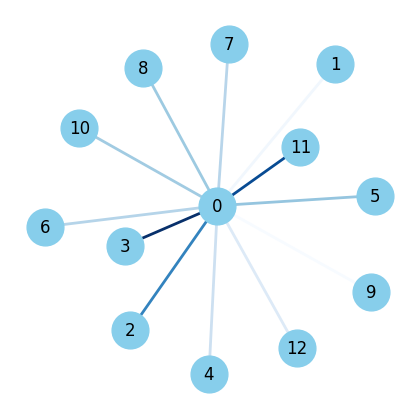

In [187]:
coral.utils.visualize_attention_graph(dataloader.dataset[0].edge_index, attn_weights_all)

/oak/stanford/groups/quake/siyu/Coral_project/notebooks/0.ExtendedDataFig1/../../coral/utils/visualization.py:502: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  plt.ylabel('Density')
/oak/stanford/groups/quake/siyu/Coral_project/notebooks/0.ExtendedDataFig1/../../coral/utils/visualization.py:503: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  plt.show()


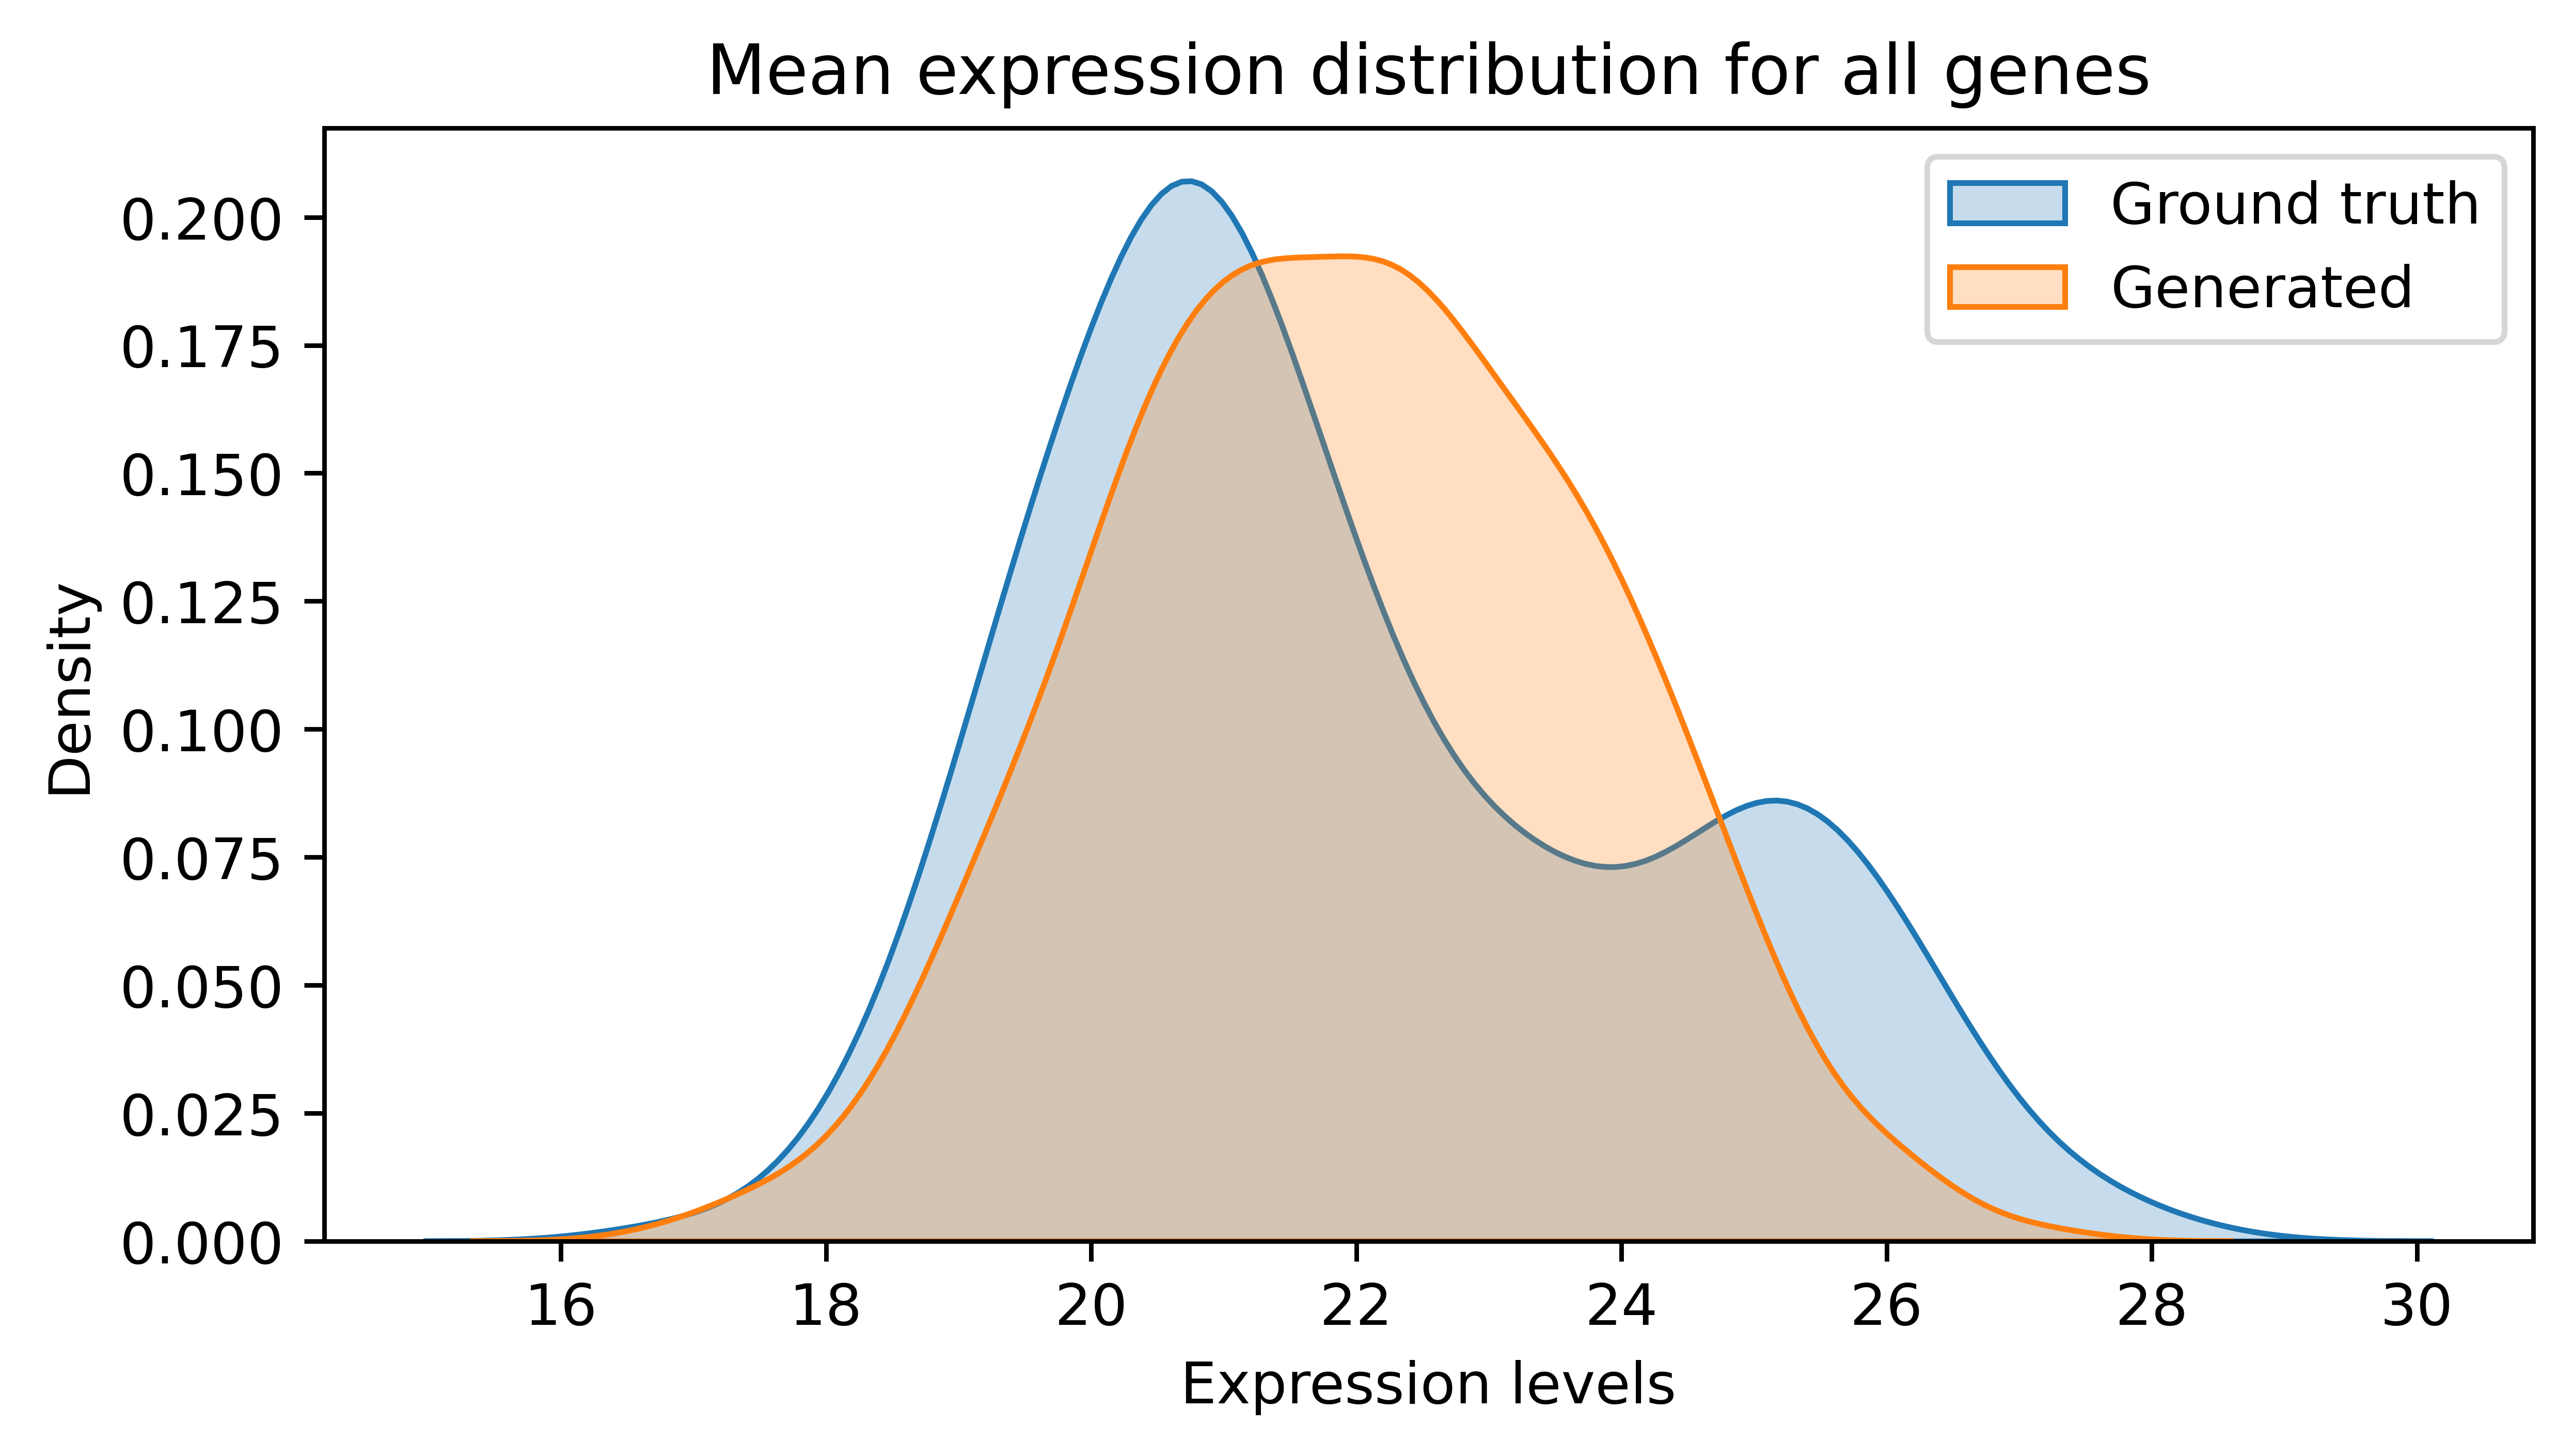

In [203]:
# Example: Compare expression for the first 5 genes
gene_indices =list(np.linspace(0,999,1000).astype(int))
gene_names = adata_rna.var_names[gene_indices]
coral.utils.compare_gene_expression_all(combined_expr, 
                                        adata_model_gener.obsm['generated_expr'],
                                        gene_indices, gene_names,
                                        mean_bool = True
                                        
                                       )


/oak/stanford/groups/quake/siyu/Coral_project/notebooks/0.ExtendedDataFig1/../../coral/utils/visualization.py:502: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  plt.ylabel('Density')
/oak/stanford/groups/quake/siyu/Coral_project/notebooks/0.ExtendedDataFig1/../../coral/utils/visualization.py:503: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  plt.show()


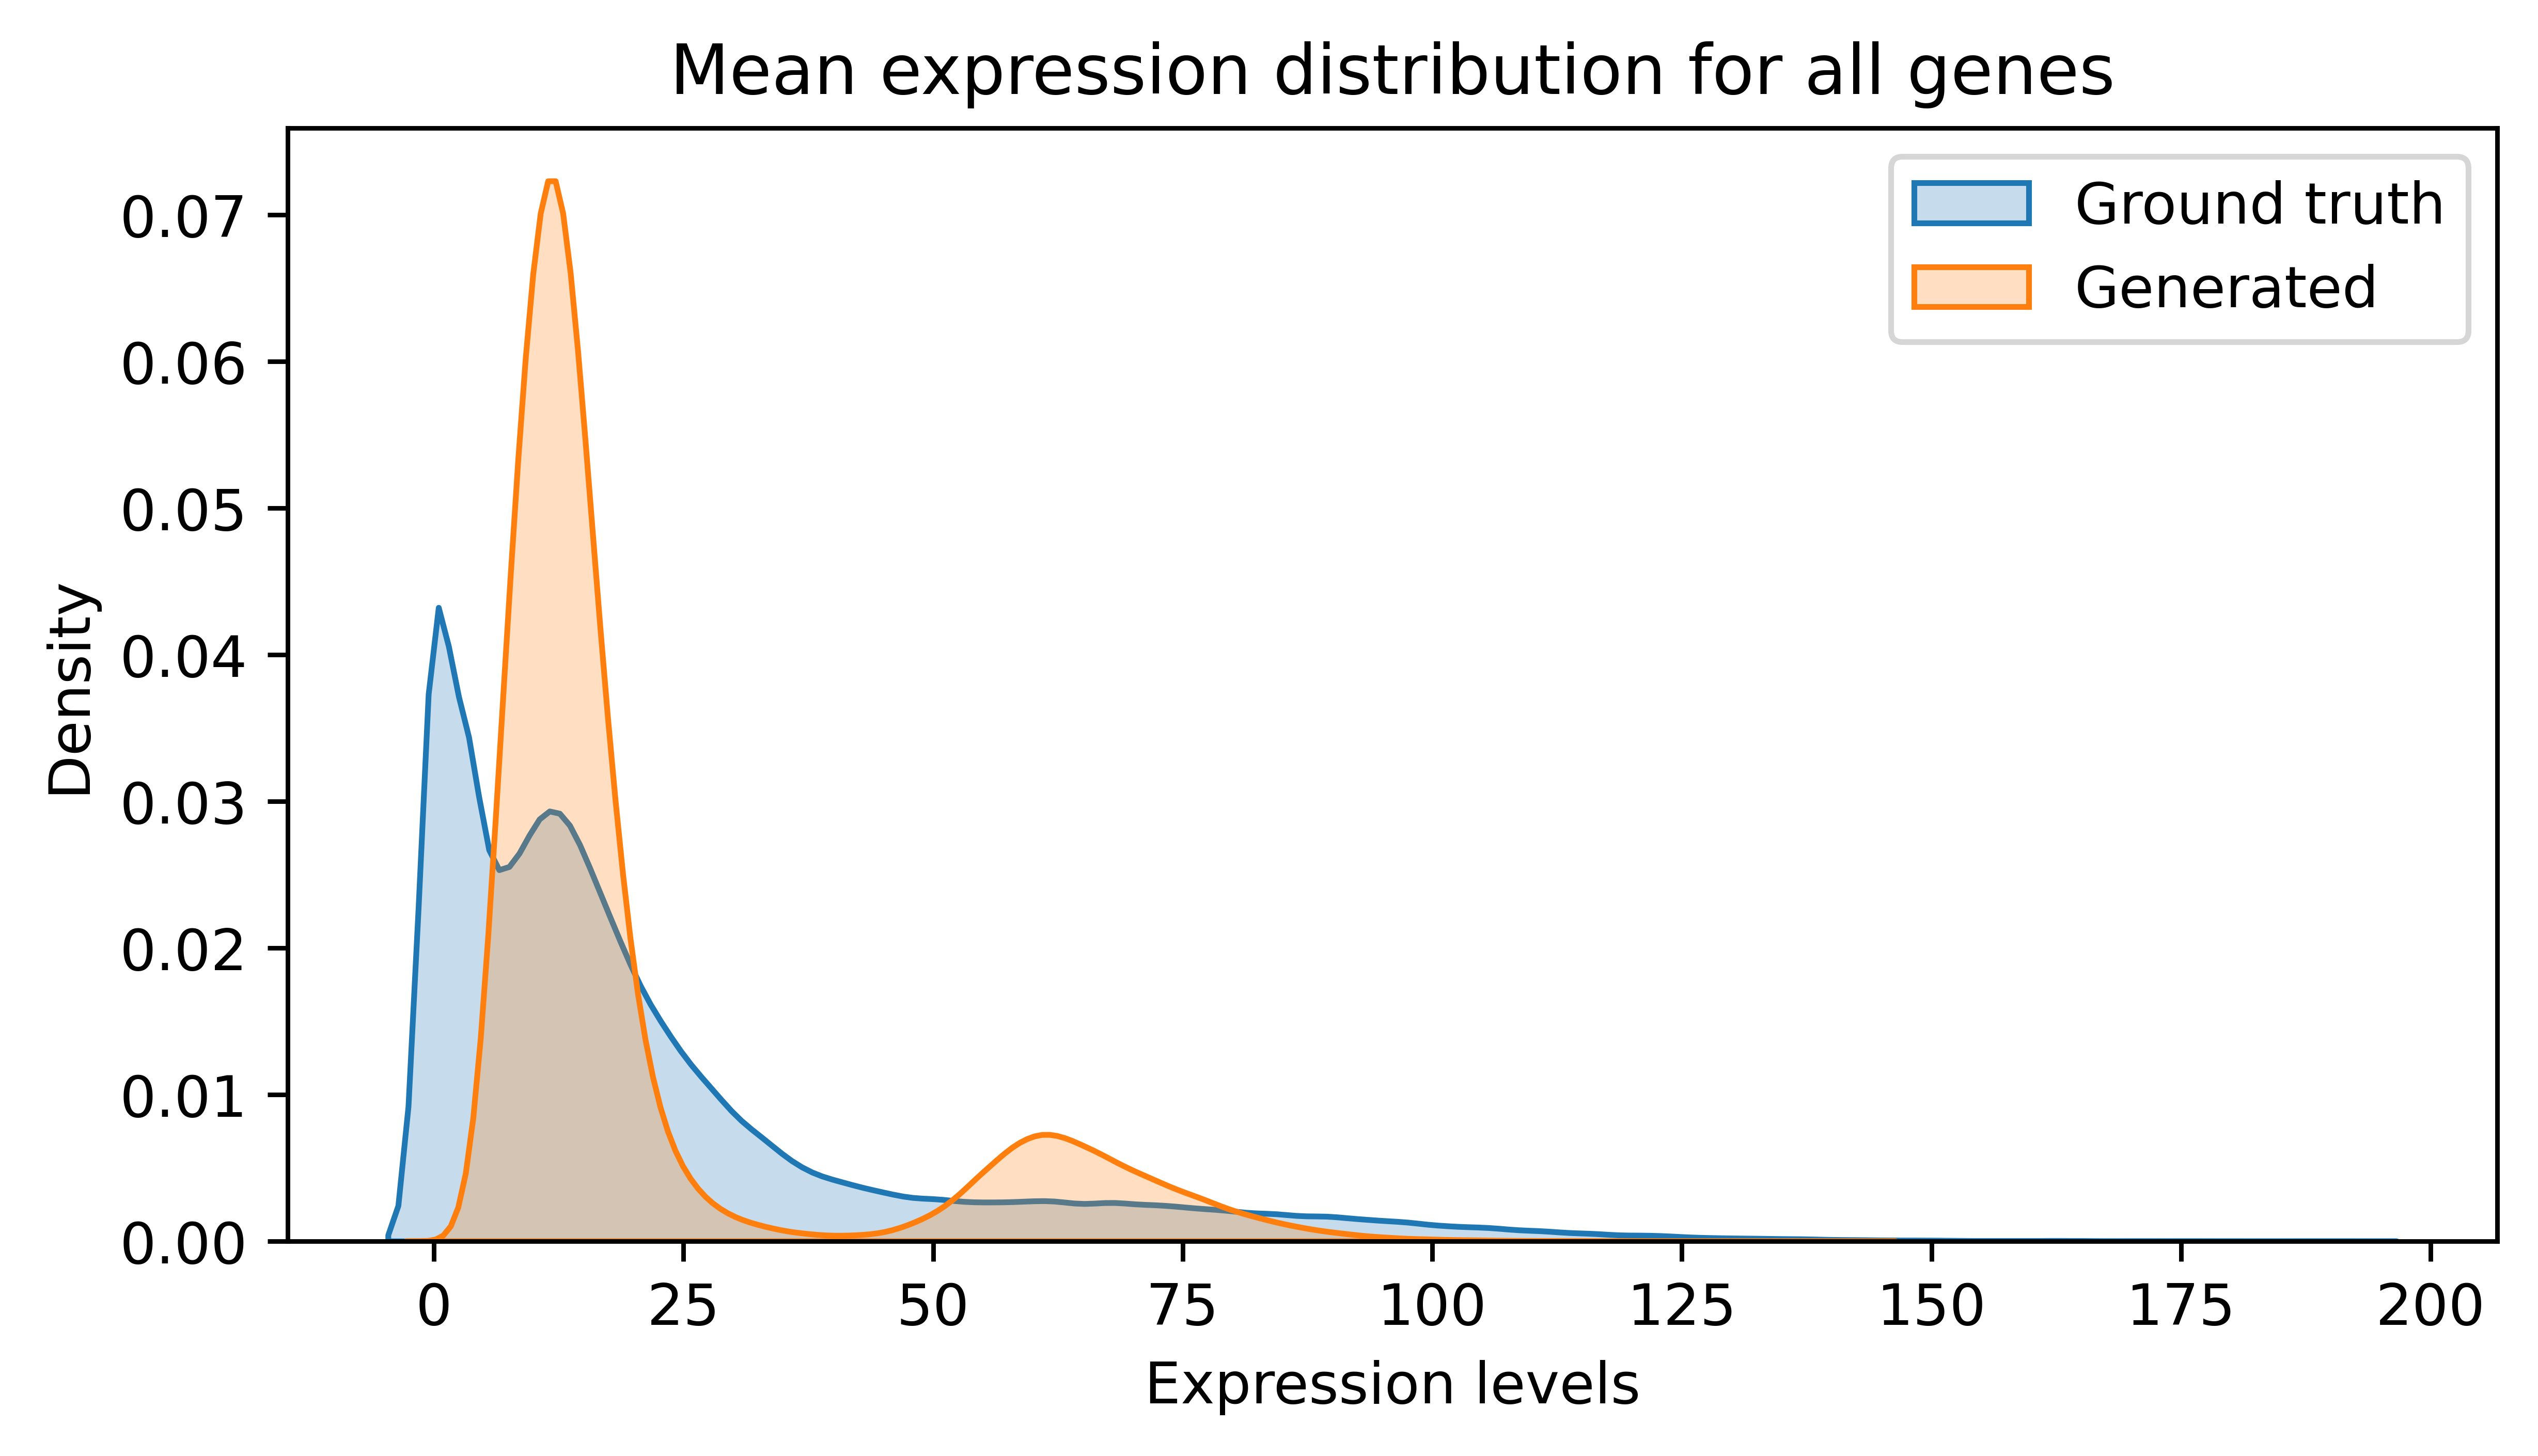

In [204]:
# Example: Compare expression for the first 5 genes
gene_indices =list(np.linspace(0,999,1000).astype(int))
gene_names = adata_rna.var_names[gene_indices]
coral.utils.compare_gene_expression_all(combined_expr, 
                                        adata_model_gener.obsm['generated_expr'],
                                        gene_indices, gene_names,
                                        mean_bool = False
                                        
                                       )


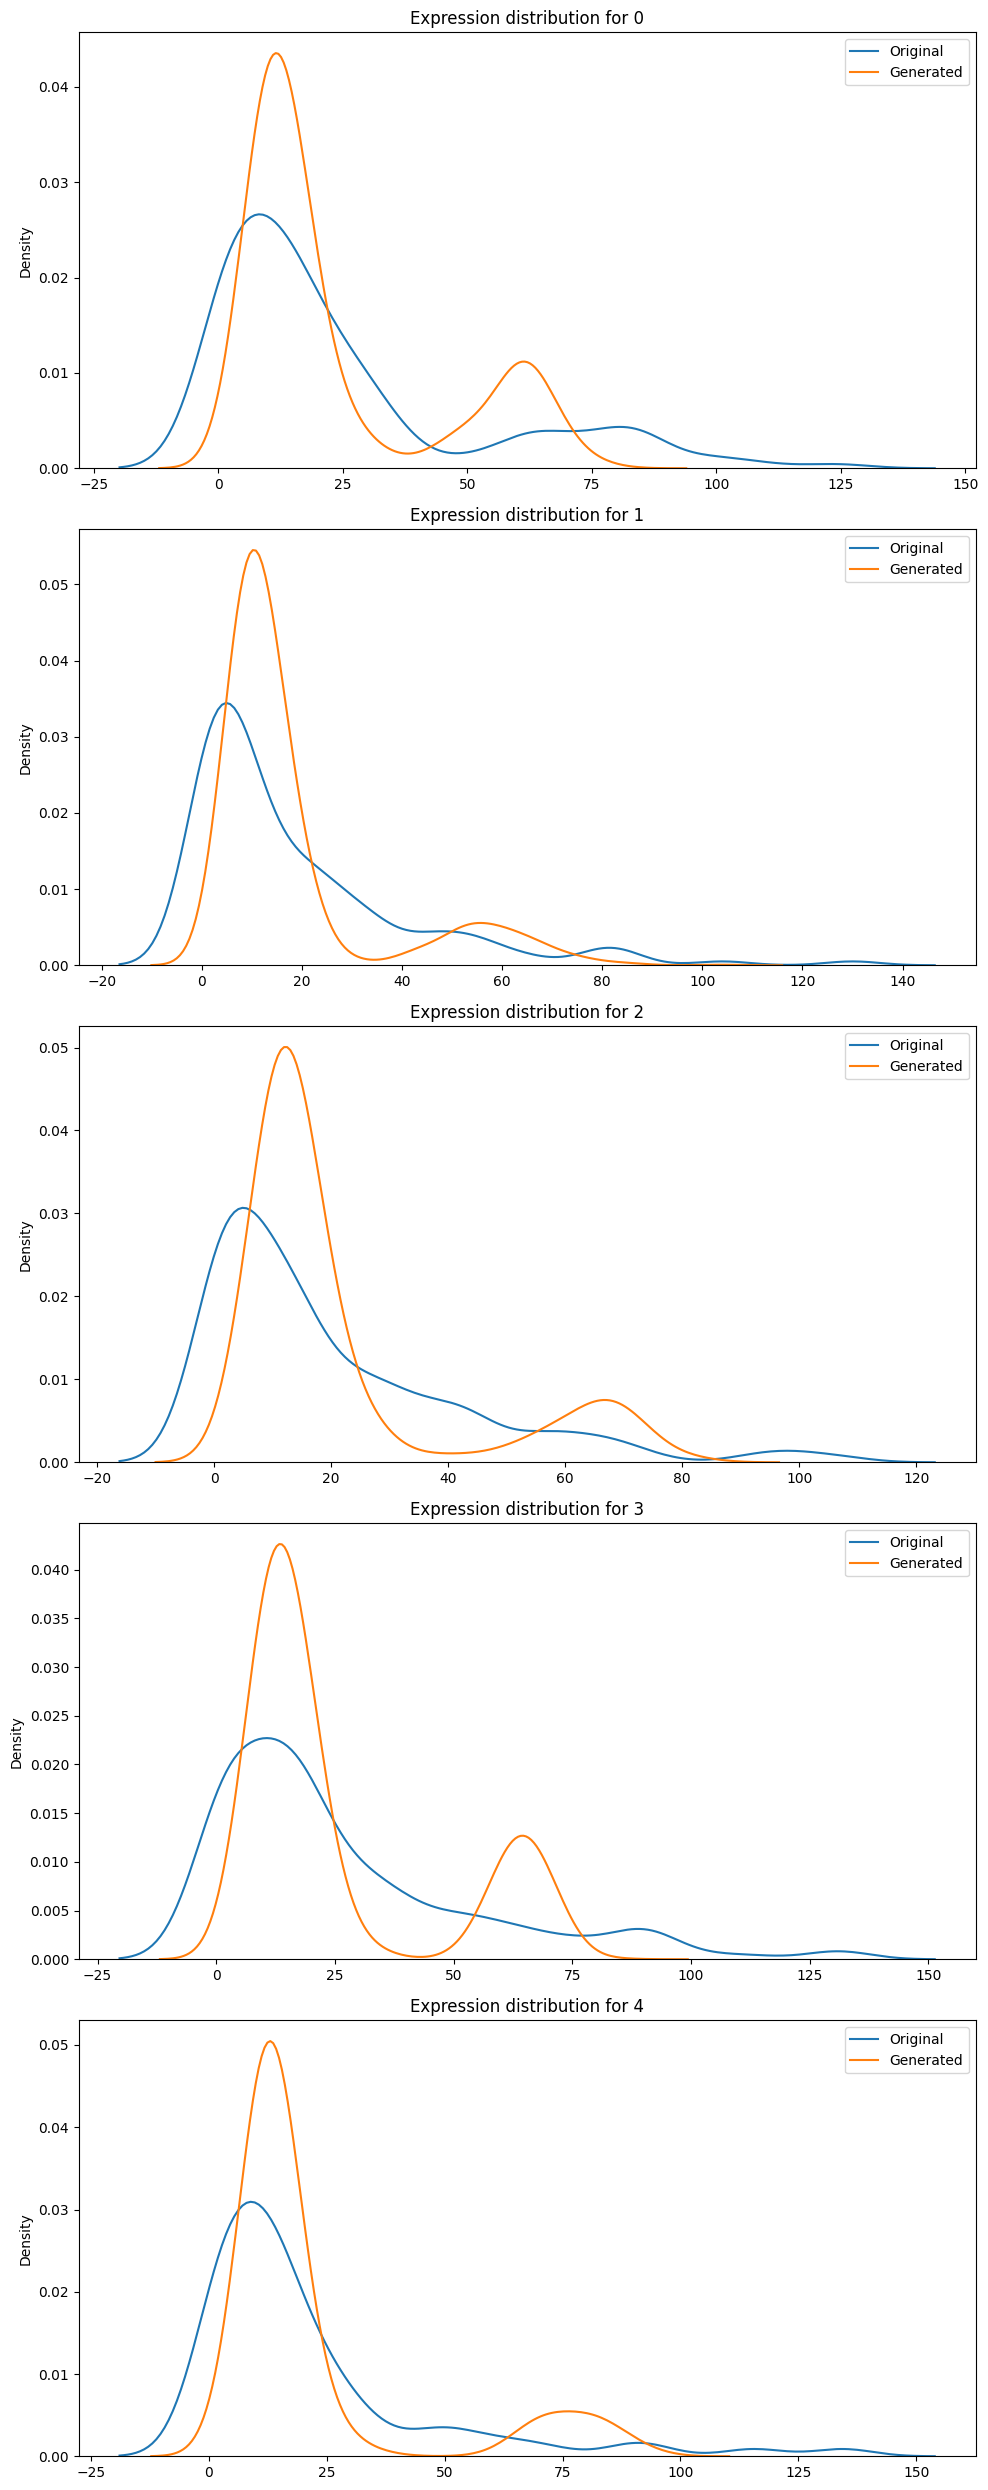

In [209]:
# Example: Compare expression for the first 5 genes
gene_indices = [0, 1, 2, 3, 4]
gene_names = adata_rna.var_names[gene_indices]
coral.utils.compare_gene_expression(combined_expr, adata_model_gener.obsm['generated_expr'], gene_indices, gene_names)

([], [])

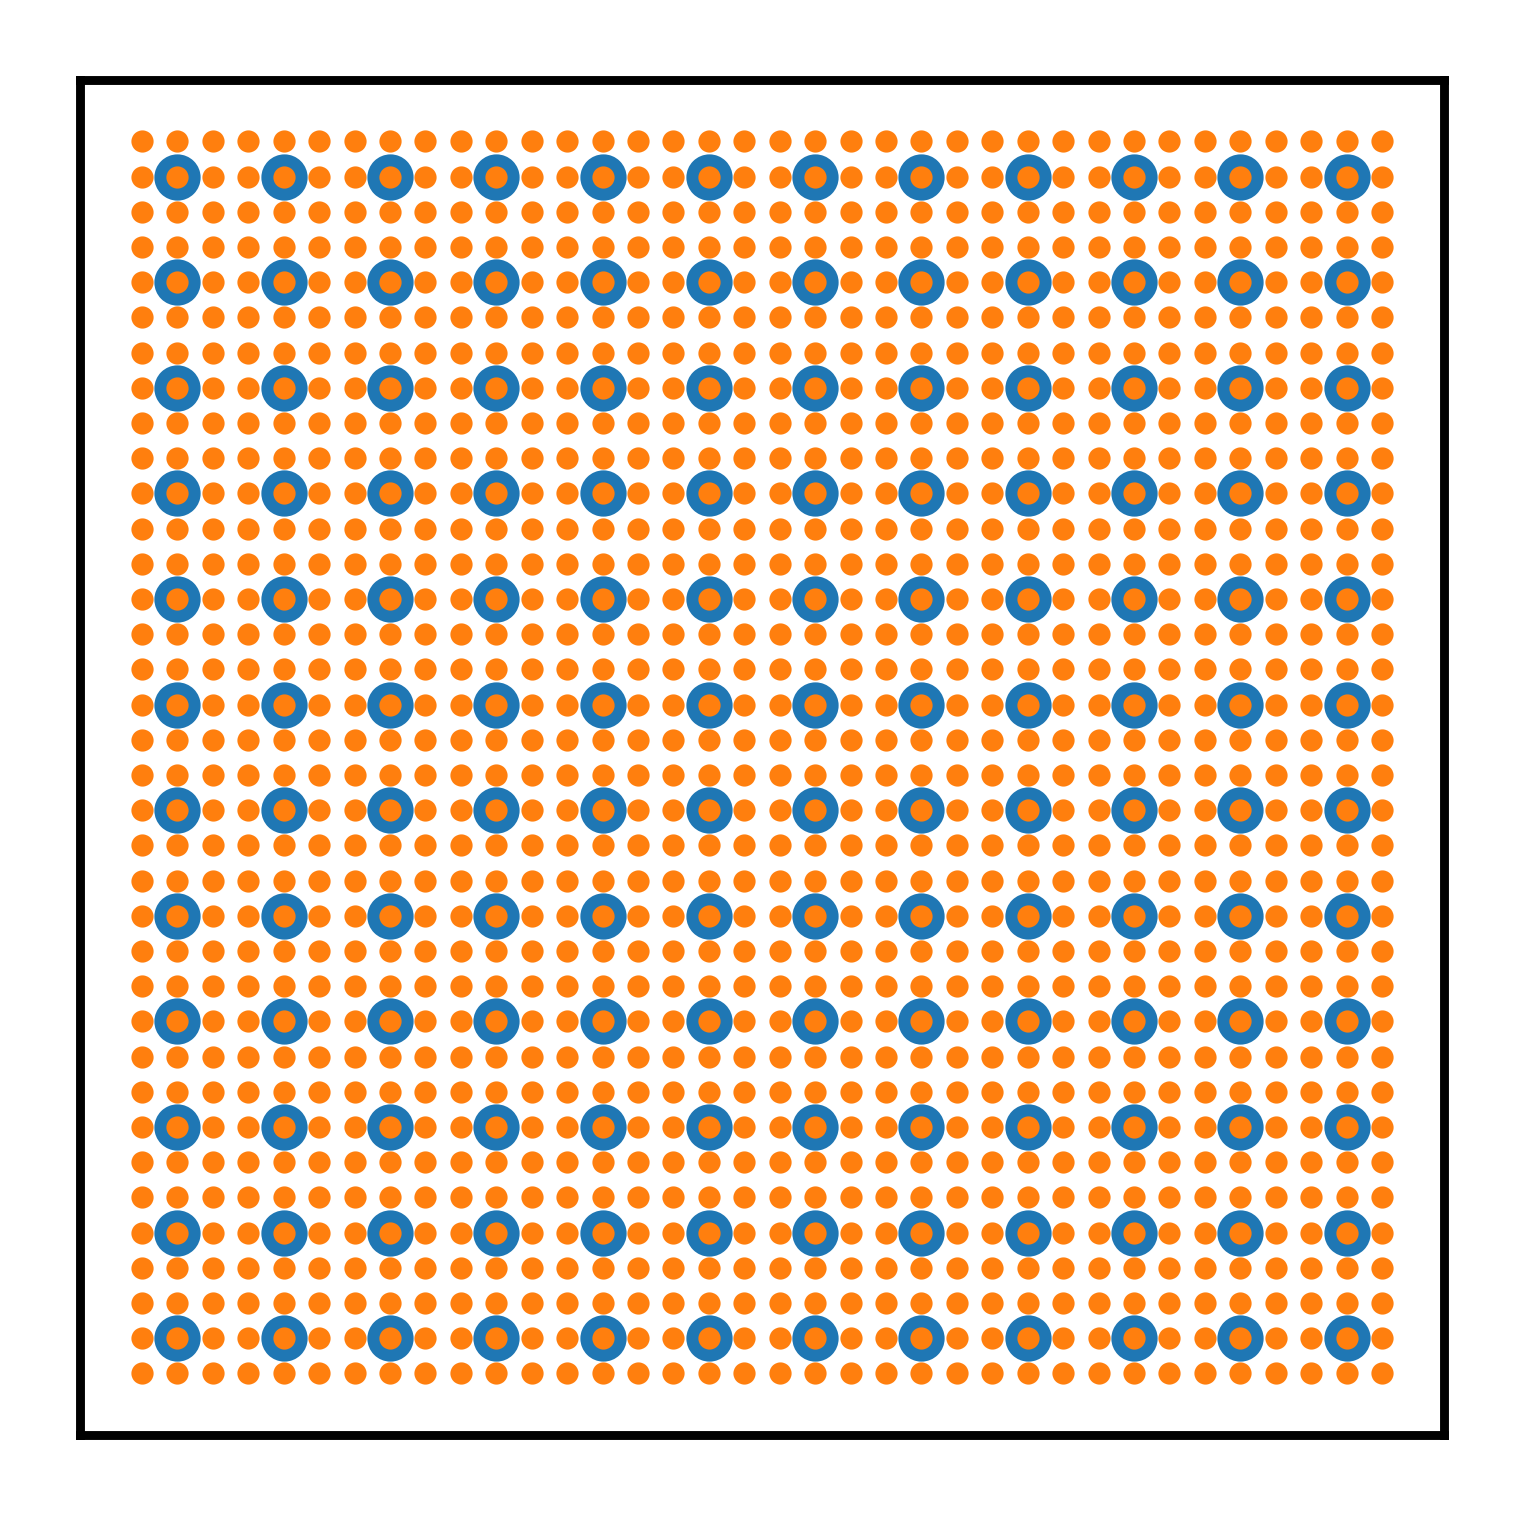

In [210]:
plt.subplots(1,1,figsize=(2.2,2.2),dpi=800)
plt.scatter(adata_downsampled.obsm['spatial'][:,0],
            adata_downsampled.obsm['spatial'][:,1],
            s=10
           )

plt.scatter(adata_adt.obsm['spatial'][:,0],
            adata_adt.obsm['spatial'][:,1],
            s=1
           )
plt.yticks([])
plt.xticks([])